In [10]:
import py_compile
py_compile.compile('MigrationUtils.py')

from os import path
import pandas as pd
import MigrationUtils as mg
import warnings
import math

file_directory = "../../Large wounds/Blinded"
metadata = pd.read_csv(path.join(file_directory, "metadata.csv"), encoding="latin-1")
key = pd.read_csv(path.join(file_directory, "key.csv"))
scale = 4.4053
pixels_per_micron = 2.2
time_scale = 11

experiments = []
for _, id, date, condition, index in key[["movie_id", "date", "condition", "index"]].itertuples():
    file_path = path.join(file_directory, str(id))

    corresponding_key = metadata.loc[metadata["movie_id"] == id]
    if corresponding_key["is_excluded"].iloc[0] == "Y":
        continue
    
    secondary_scale = 1/corresponding_key["scale"].iloc[0]
    if pd.isna(secondary_scale):
        secondary_scale = scale
    try:
        tracks = mg.tracks_from_xml(file_path + ".xml", scale=secondary_scale/pixels_per_micron)
        margin = mg.margin_from_csv(file_path + ".csv", scale=1/pixels_per_micron)
    except FileNotFoundError:
        warnings.warn(f"Could not find {id}.csv or {id}.xml in {file_directory}")
        continue
    
    start_time = float(corresponding_key["start_time"].iloc[0])
    stop_time = float(corresponding_key["stop_time"].iloc[0])
    if pd.isna(start_time):
        start_time = 0
    if pd.isna(stop_time):
        stop_time = math.inf
    
    for i in range(len(tracks)):
        tracks[i].scale(time_scale, 1)

    experiments.append(
        mg.Experiment(tracks, margin, condition, date, start_time*time_scale, stop_time*time_scale, index)
    )

    lin_start_time = float(corresponding_key["linear_start_time"].iloc[0])
    lin_stop_time = float(corresponding_key["linear_stop_time"].iloc[0])
    if pd.isna(lin_start_time):
        lin_start_time = 0
    if pd.isna(lin_stop_time):
        lin_stop_time = math.inf
    experiments[-1].blind_id = id
    experiments[-1].linear_range = (lin_start_time, lin_stop_time)

FileNotFoundError: [Errno 2] No such file or directory: '../../Large wounds/Blinded/blind_key.csv'

Number of experiments: 21
Apyrase: 11
Water: 10


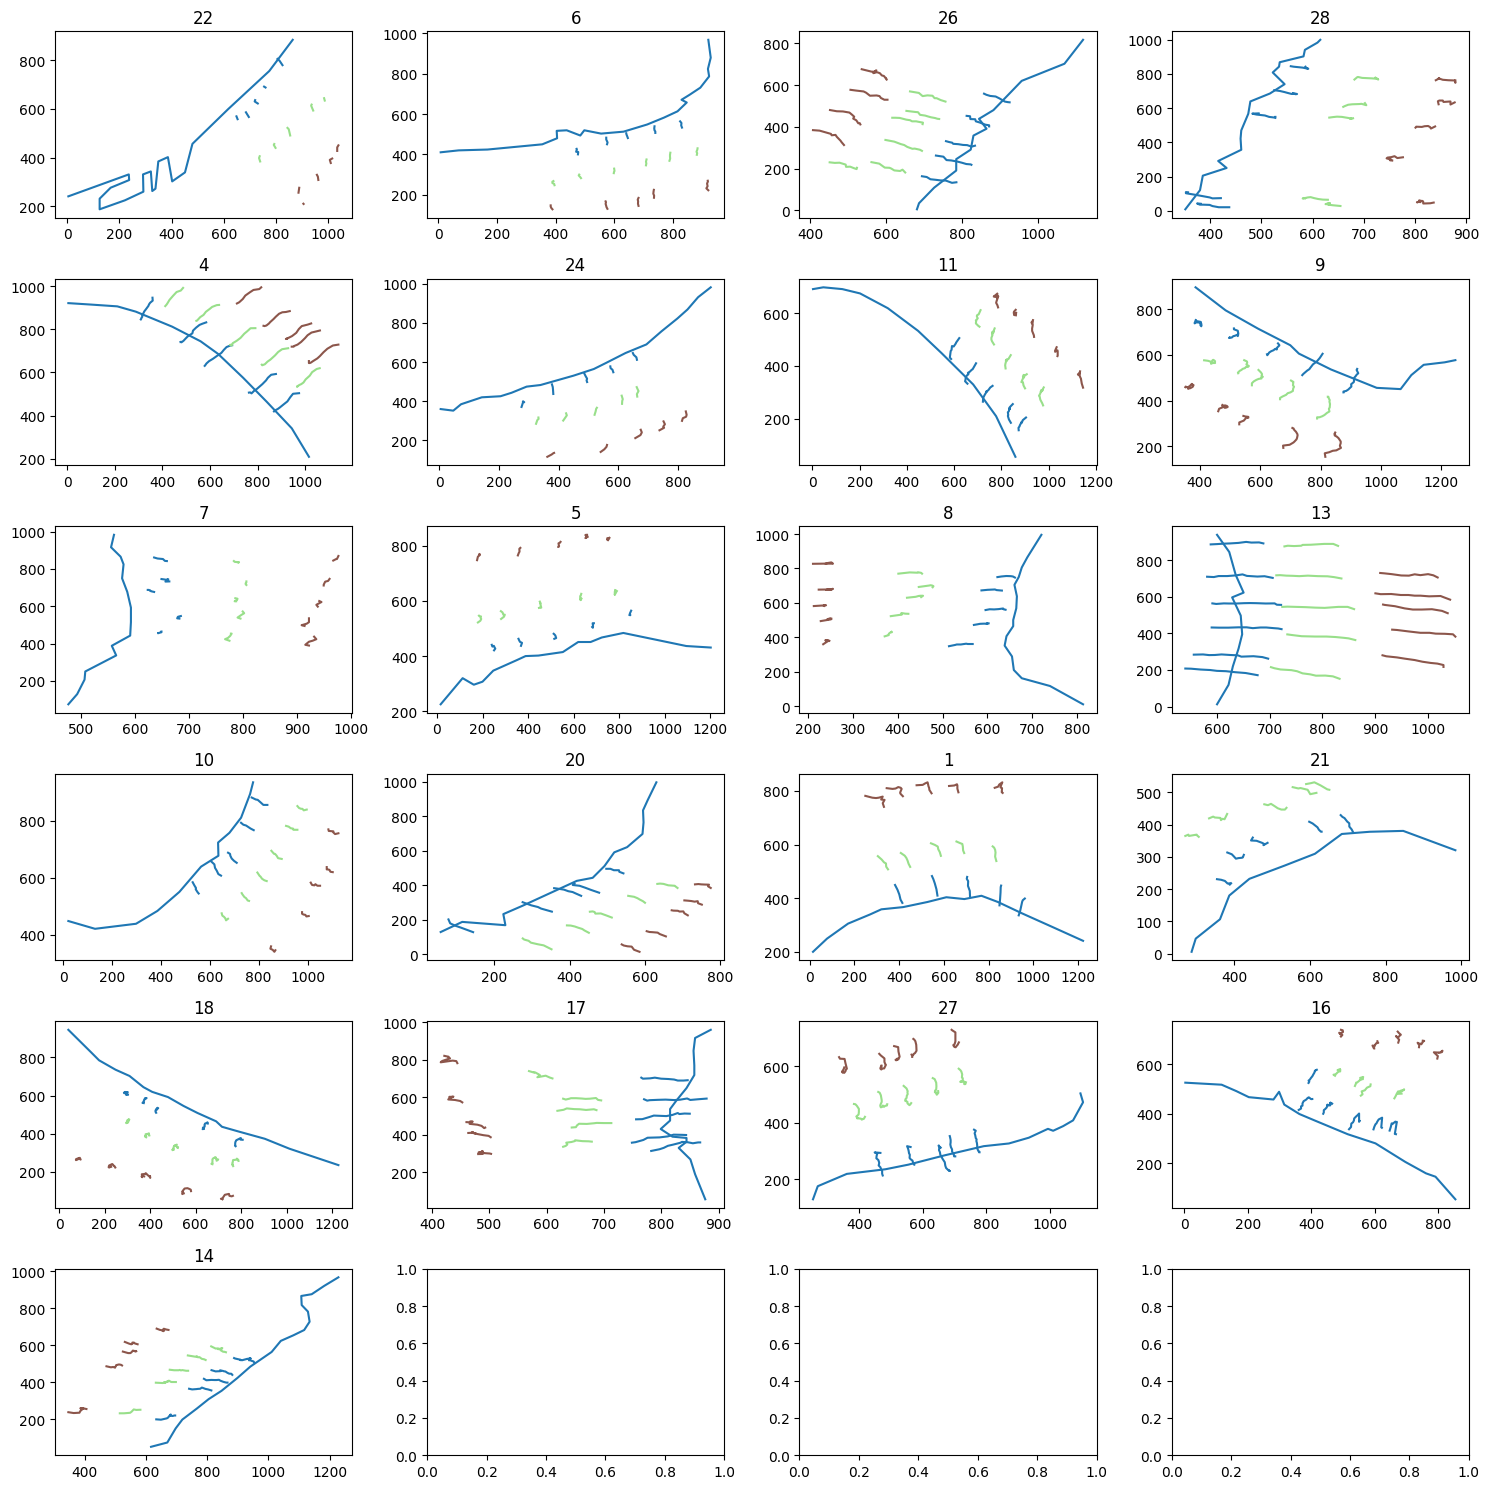

In [ ]:
import numpy as np
from matplotlib import colormaps
from matplotlib import pyplot as plt

cell_width = 20 * scale/pixels_per_micron
dist_bins = list(np.array([0, 75, 150, math.inf]) * scale/pixels_per_micron)

cm = colormaps.get_cmap("tab20")
N = len(dist_bins)
colors = [cm(i/N) for i in range(N)]

fig, axs = plt.subplots(6, 4)
axs_flat = [x for xs in axs for x in xs]
fig.set_size_inches(15, 15)

for i, exp in enumerate(experiments):
    ax = axs_flat[i]
    mg.plot_tracks_by_bin(exp.tracks, exp.margin, dist_bins, colors=colors, fig=fig, ax=ax)
    ax.set_title(exp.blind_id)

plt.tight_layout()
print(f"Number of experiments: {len(experiments)}")
apy_exp = [exp for exp in experiments if exp.condition == "Apyrase"]
water_exp = [exp for exp in experiments if exp.condition == "Water"]
print(f"Apyrase: {len(apy_exp)}")
print(f"Water: {len(water_exp)}")

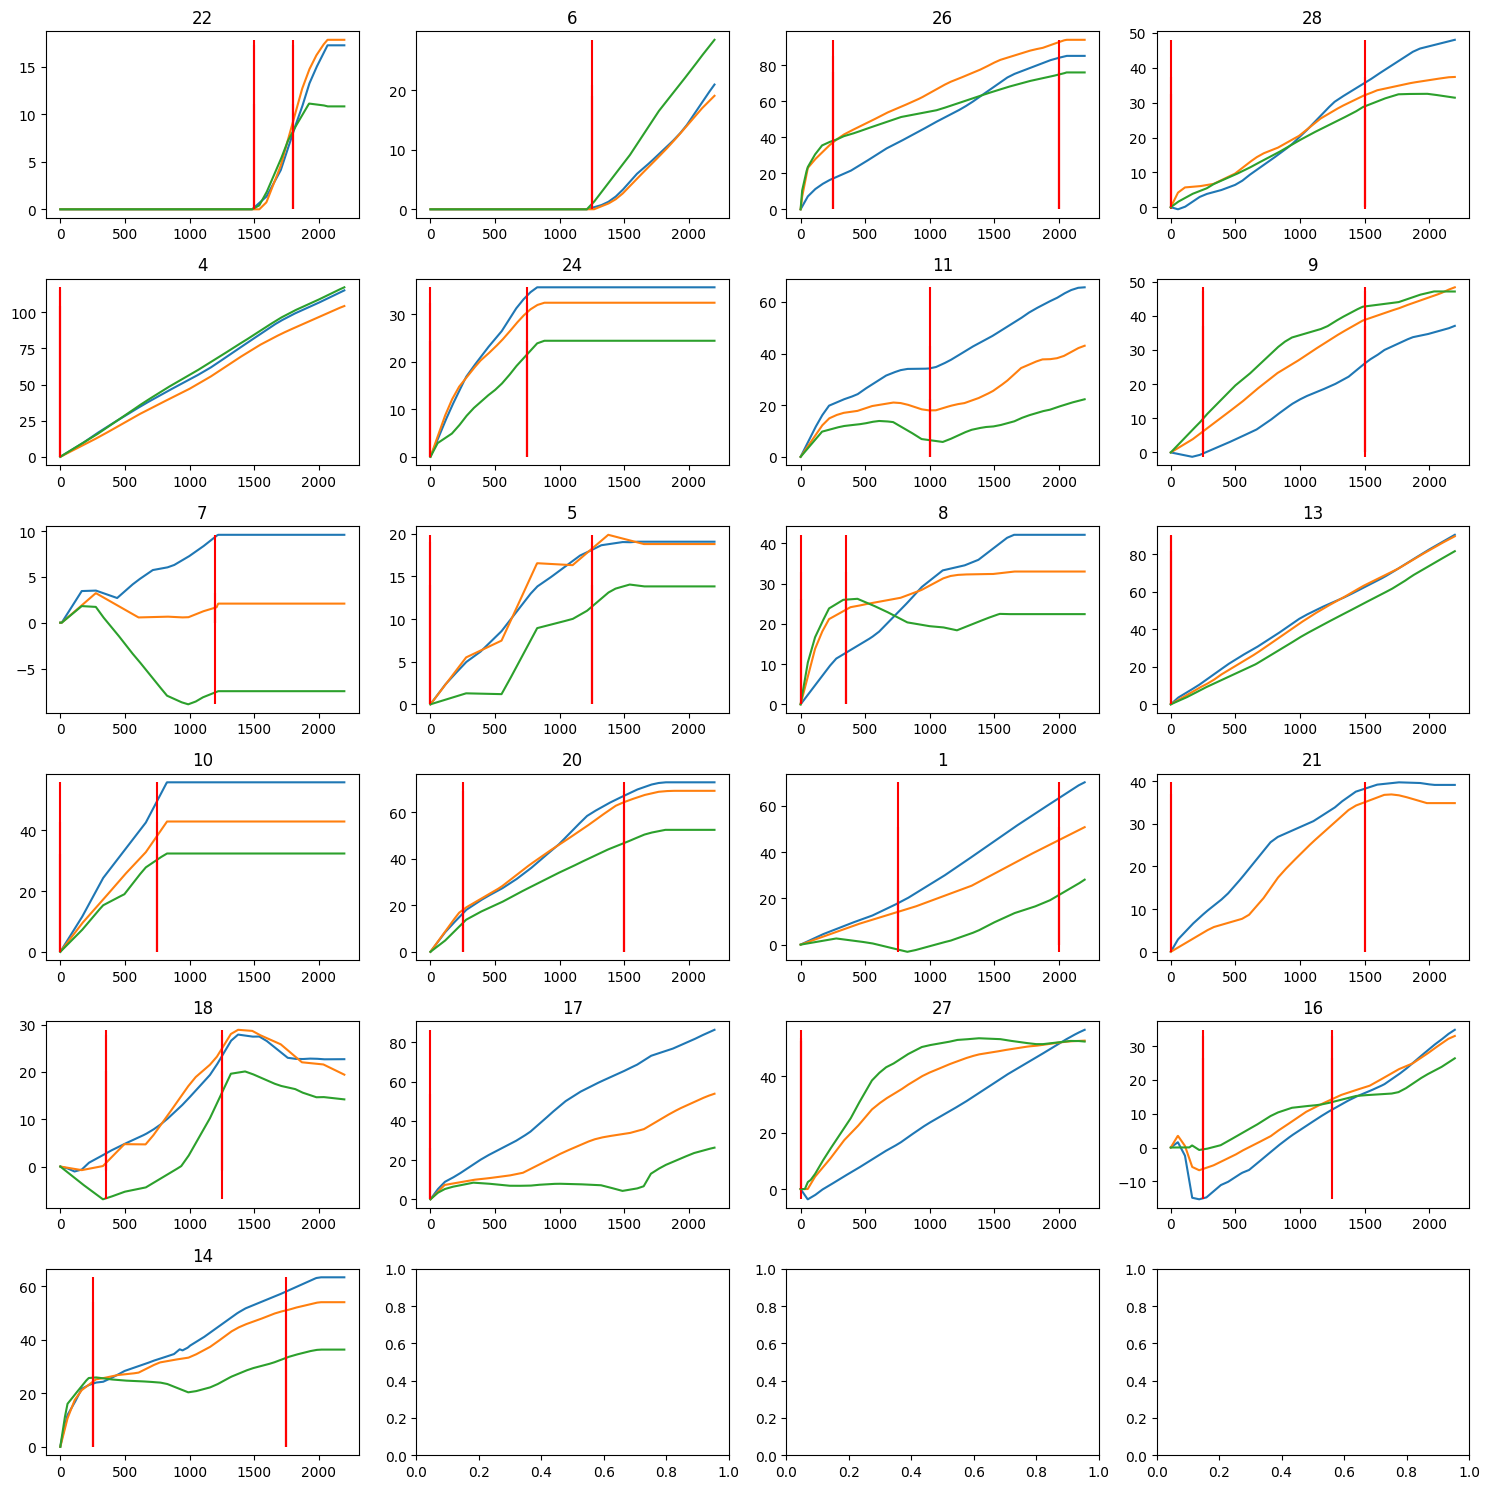

In [ ]:
fig, axs = plt.subplots(6, 4)
axs_flat = [x for xs in axs for x in xs]
fig.set_size_inches(15, 15)

for i, exp in enumerate(experiments):
    bins = exp.bin_tracks(dist_bins)
    for bin in bins:
        if len(bin["tracks"]) == 0:
            continue

        traj_ = exp.to_trajectories(bin["tracks"],
                                    num_samples=100*time_scale,
                                    max_time=200*time_scale)
        mean_traj = mg.average_trajectories(traj_)
        axs_flat[i].plot(mean_traj.times, mean_traj.displacements)
        axs_flat[i].set_title(exp.blind_id)
        axs_flat[i].vlines(exp.linear_range, color="red", 
                           ymin=min(mean_traj.displacements), ymax=max(mean_traj.displacements))

plt.tight_layout()

/var/folders/hm/k1cnzt3x171brxs3ps57yx4h0000gn/T/ipykernel_17080/2169875476.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  sns.swarmplot(


<Axes: xlabel='bin_start', ylabel='mean_speed'>

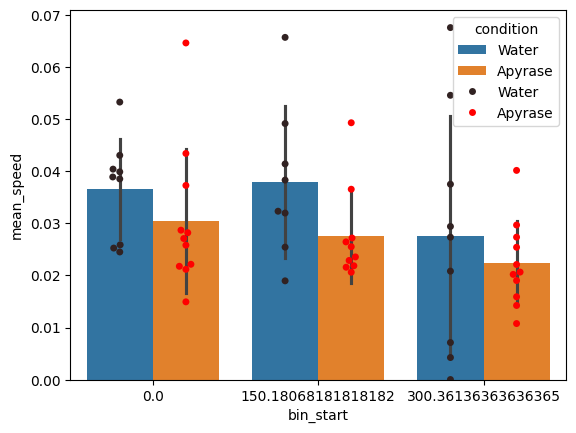

In [ ]:
import seaborn as sns

speed_df = pd.DataFrame({"date": [], "condition": [], "bin_start": [], "bin_end": [], "mean_speed": []})

for i, exp in enumerate(experiments):
    bins = exp.bin_tracks(dist_bins)
    for bin in bins:
        if len(bin["tracks"]) == 0:
            continue
        trajs = exp.to_trajectories(bin["tracks"],
                                    num_samples=100*time_scale,
                                    max_time=200*time_scale)
        speeds = [traj.compute_average_speed(start=exp.linear_range[0], end=exp.linear_range[1]) for traj in trajs]
        mean_speed = sum(speeds)/len(speeds)
        if (mean_speed > 0.12):
            print(exp.blind_id, bin["start"], mean_speed)
        speed_df.loc[len(speed_df.index)] = [exp.date, exp.condition, bin["start"], bin["end"], mean_speed]

pruned_speed_df = speed_df.loc[speed_df["mean_speed"] > 0.1]

sns.barplot(
    speed_df,
    x="bin_start",
    y="mean_speed",
    hue="condition",
    errorbar="sd"
)

sns.swarmplot(
    speed_df,
    x="bin_start",
    y="mean_speed",
    hue="condition",
    dodge=True,
    color="red"
)

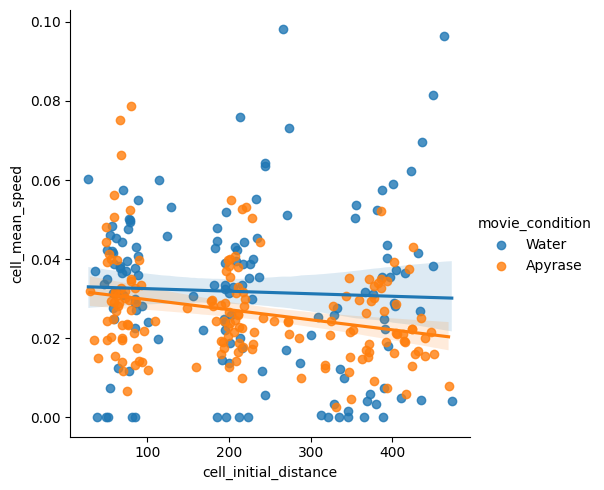

In [ ]:
## Data export

cell_df = pd.DataFrame({"movie_id":[], "movie_date":[], "movie_condition":[], "movie_index":[],
                         "cell_id": [], "cell_mean_speed":[], "cell_initial_distance":[]})
for exp in experiments:
    for i, track in enumerate(exp.tracks):
        traj = track.compute_trajectory(exp.margin).resample(100*time_scale, 0, max_time=200*time_scale)
        mean_speed = traj.compute_average_speed(start=exp.linear_range[0],
                                    end=exp.linear_range[1])
        initial_distance = track.compute_initial_distance(exp.margin)
        cell_df.loc[len(cell_df.index)] = [exp.blind_id, exp.date, exp.condition, exp.index, 
                                           i, mean_speed, initial_distance]

sns.lmplot(
    data=cell_df,
    x="cell_initial_distance",
    y="cell_mean_speed",
    hue="movie_condition"
)
        


In [ ]:
from scipy import stats

bin1 = cell_df.loc[cell_df["cell_initial_distance"] < 250].dropna()

stats.f_oneway(bin1.loc[bin1["movie_condition"] == "Apyrase"]["cell_mean_speed"],
               bin1.loc[bin1["movie_condition"] == "Water"]["cell_mean_speed"])

F_onewayResult(statistic=2.8772825262667054, pvalue=0.09142514914637107)

<Axes: xlabel='bin', ylabel='cell_mean_speed'>

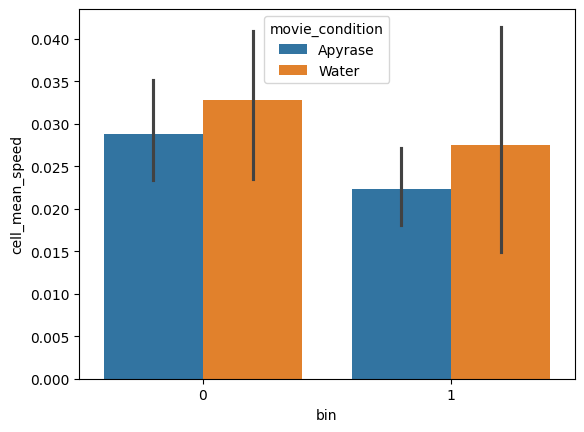

In [ ]:
def get_bin(dist):
    if dist < 250:
        return 0
    elif dist < 625:
        return 1
    else:
        return 2

cell_df["bin"] = cell_df.apply(lambda row: get_bin(row["cell_initial_distance"]), axis=1)

binned_df = cell_df.groupby(["movie_id", "movie_condition", "bin"], as_index=False)["cell_mean_speed"].agg("mean")

sns.barplot(
    data=binned_df,
    x="bin",
    y="cell_mean_speed",
    hue="movie_condition"
)

In [ ]:
stats.f_oneway(binned_df.loc[(binned_df["bin"]==1) & (binned_df["movie_condition"]=="Apyrase")]["cell_mean_speed"], 
               binned_df.loc[(binned_df["bin"]==1) & (binned_df["movie_condition"]=="Water")]["cell_mean_speed"])

F_onewayResult(statistic=0.5038538355721933, pvalue=0.4869062267463715)